Version 1.0.2

# Pandas basics 

Hi! In this programming assignment you need to refresh your `pandas` knowledge. You will need to do several [`groupby`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html)s and [`join`]()`s to solve the task. 

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 

from grader import Grader

In [2]:
DATA_FOLDER = '../readonly/final_project_data/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

The dataset we are going to use is taken from the competition, that serves as the final project for this course. You can find complete data description at the [competition web page](https://www.kaggle.com/c/competitive-data-science-final-project/data). To join the competition use [this link](https://www.kaggle.com/t/1ea93815dca248e99221df42ebde3540).

## Grading

We will create a grader instace below and use it to collect your answers. When function `submit_tag` is called, grader will store your answer *locally*. The answers will *not* be submited to the platform immediately so you can call `submit_tag` function as many times as you need. 

When you are ready to push your answers to the platform you should fill your credentials and run `submit` function in the <a href="#Authorization-&-Submission">last paragraph</a>  of the assignment.

In [3]:
grader = Grader()

# Task

Let's start with a simple task. 

<ol start="0">
  <li><b>Print the shape of the loaded dataframes and use [`df.head`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html) function to print several rows. Examine the features you are given.</b></li>
</ol>

In [4]:
print('transactions')
print(transactions.shape)
print(transactions.head())
print('items')
print(items.shape)
print(items.head())
print('item_categories')
print(item_categories.head())
print(item_categories.shape)
print('shops')
print(shops.shape)
print(shops.head())

transactions
(2935849, 6)
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
items
(22170, 3)
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4           

Now use your `pandas` skills to get answers for the following questions. 
The first question is:

1. ** What was the maximum total revenue among all the shops in September, 2014?** 


* Hereinafter *revenue* refers to total sales minus value of goods returned.

*Hints:*

* Sometimes items are returned, find such examples in the dataset. 
* It is handy to split `date` field into [`day`, `month`, `year`] components and use `df.year == 14` and `df.month == 9` in order to select target subset of dates.
* You may work with `date` feature as with srings, or you may first convert it to `pd.datetime` type with `pd.to_datetime` function, but do not forget to set correct `format` argument.

In [5]:
data = transactions.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_')
data['day'] = data['date'].map(lambda x: int(x[0:2]))
data['month'] = data['date'].map(lambda x: int(x[3:5]))
data['year'] = data['date'].map(lambda x: int(x[6:10]))
data['revenue'] = data['item_price'] * data['item_cnt_day']

sp_2014_sep = data.query("month == 9 and year == 2014")

gp_sp_revenue = sp_2014_sep.groupby(['shop_id'])['revenue'].agg('sum')

max_revenue = gp_sp_revenue.sort_values(ascending=False).head(1).values[0]
grader.submit_tag('max_revenue', max_revenue)

Current answer for task max_revenue is: 7982852.2


Great! Let's move on and answer another question:

<ol start="2">
  <li><b>What item category generated the highest revenue in summer 2014?</b></li>
</ol>

* Submit `id` of the category found.
    
* Here we call "summer" the period from June to August.

*Hints:*

* Note, that for an object `x` of type `pd.Series`: `x.argmax()` returns **index** of the maximum element. `pd.Series` can have non-trivial index (not `[1, 2, 3, ... ]`).

In [6]:
summer_2014 = data.query("month >= 6 and month <= 8 and year == '2014'")

gp_cat_revenue = summer_2014.groupby(['item_category_id'])['revenue'].agg('sum')

category_id_with_max_revenue = gp_cat_revenue.sort_values(ascending=False).index[0]
grader.submit_tag('category_id_with_max_revenue', category_id_with_max_revenue)

Current answer for task category_id_with_max_revenue is: 20


<ol start="3">
  <li><b>How many items are there, such that their price stays constant (to the best of our knowledge) during the whole period of time?</b></li>
</ol>

* Let's assume, that the items are returned for the same price as they had been sold.

In [7]:
gp_items_prices = data.groupby(['item_id'])['item_price'].agg(['min', 'max']).reset_index()
# gp_items_prices = gp_items_prices.query('min == max')
gp_items_prices['minn'] = gp_items_prices['min']
gp_items_prices['maxx'] = gp_items_prices['max']
gp_items_prices = gp_items_prices.query('minn == maxx')

num_items_constant_price = gp_items_prices.shape[0]
grader.submit_tag('num_items_constant_price', num_items_constant_price)

Current answer for task num_items_constant_price is: 5926


Remember, the data can sometimes be noisy.

<ol start="4">
  <li><b>What was the variance of the number of sold items per day sequence for the shop with `shop_id = 25` in December, 2014? Do not count the items, that were sold but returned back later.</b></li>
</ol>

* Fill `total_num_items_sold` and `days` arrays, and plot the sequence with the code below.
* Then compute variance. Remember, there can be differences in how you normalize variance (biased or unbiased estimate, see [link](https://math.stackexchange.com/questions/496627/the-difference-between-unbiased-biased-estimator-variance)). Compute ***unbiased*** estimate (use the right value for `ddof` argument in `pd.var` or `np.var`). 
* If there were no sales at a given day, ***do not*** impute missing value with zero, just ignore that day

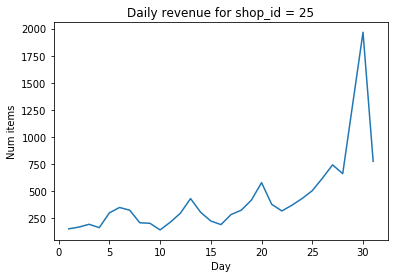

Current answer for task total_num_items_sold_var is: 117167.702299


In [8]:
shop_id = 25

sp_25_dec = data.query("year == 2014 and month == 12 and shop_id == %s" % shop_id)
gp_25_dec = sp_25_dec.groupby(['day'])['item_cnt_day'].agg('sum').reset_index()

total_num_items_sold = gp_25_dec['item_cnt_day'].values
days =  gp_25_dec['day'].values

# Plot it
plt.plot(days, total_num_items_sold)
plt.ylabel('Num items')
plt.xlabel('Day')
plt.title("Daily revenue for shop_id = 25")
plt.show()

total_num_items_sold_var = np.var(total_num_items_sold, axis=0, ddof=1)
grader.submit_tag('total_num_items_sold_var', total_num_items_sold_var)

## Authorization & Submission
To submit assignment to Cousera platform, please, enter your e-mail and token into the variables below. You can generate token on the programming assignment page. *Note:* Token expires 30 minutes after generation.

In [ ]:
STUDENT_EMAIL = # EMAIL HERE
STUDENT_TOKEN = # TOKEN HERE
grader.status()

In [ ]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Well done! :)